# Style Transfer with Deep Neural Networks


Neural style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. 

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/vgg19_convlayers.png?raw=1' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**



In [1]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load in VGG19 (features)


In [2]:
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters 
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images


In [66]:
def load_image(img_path, max_size=400, shape=None):
    
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [67]:
# load in content and style image
content = load_image('https://www.businessinsider.in/photo/78245070/The-17-tallest-buildings-in-the-world-right-now-ranked.jpg?imgsize=235953').to(device)
# Resize style to match content, makes code easier
style = load_image('https://miro.medium.com/max/2560/1*yOmBkzDKE6HuWOvrWw1E1Q.jpeg', shape=content.shape[-2:]).to(device)

In [8]:
# Helper function for un-normalizing an image and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

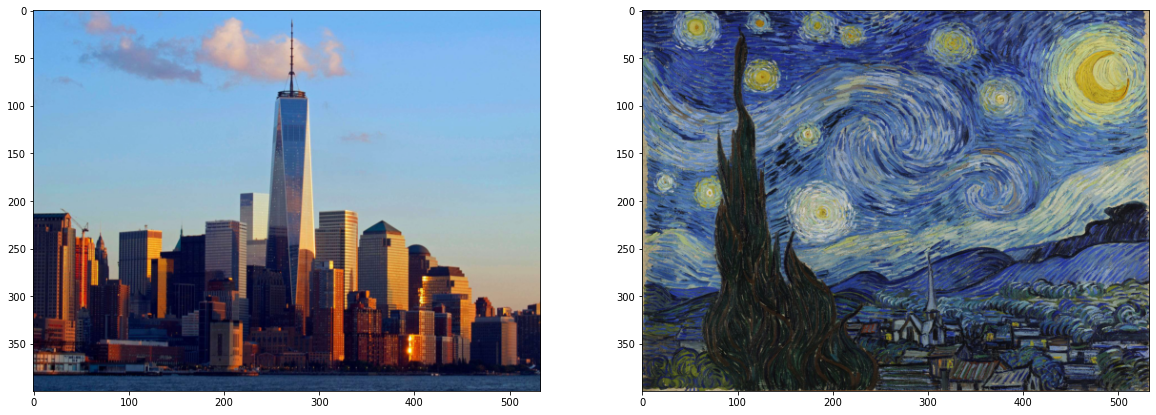

In [72]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Layers


In [10]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features



In [11]:
def get_features(image, model, layers=None):
    
  
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv5_1',
                  '28': 'conv6_1'
                  }
        
        
    
    features = {}
    x = image
   
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 



In [32]:
def gram_matrix(tensor):
   x=tensor.size()
   batch_size=x[0]
   depth=x[1]
   height=x[2]
   width=x[3]


    
    
    ## Calculate the gram matrix
   x = tensor.reshape(batch_size,depth,height*width) 
   y= x.permute(0,2,1)
   gram=x@y
    
   return gram 

## Putting it all Together



In [52]:
# Content and Style features 
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Gram matrices for each layer 
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights



In [53]:
# weights for each style layer 
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}


content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target & Calculating Losses



#### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv5_1`.

#### Style Loss

The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary `style_weights`. 
> You'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`. 
> Later, you'll see that this value is normalized by the size of the layer.

#### Total Loss

Finally, you'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!



Total loss:  25715896.0


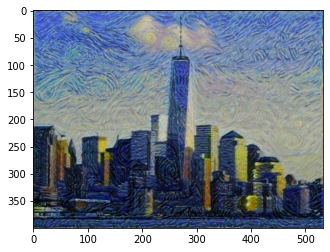

Total loss:  17302912.0


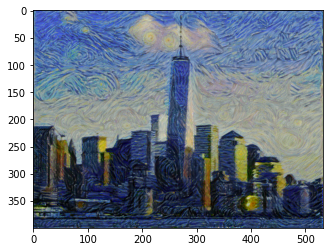

Total loss:  13047481.0


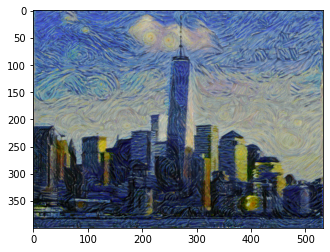

Total loss:  10552290.0


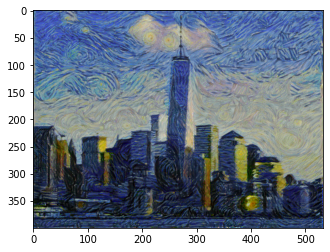

Total loss:  9021890.0


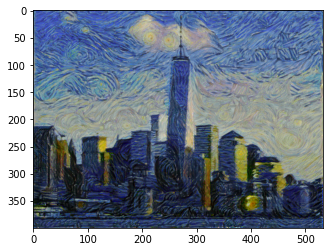

Total loss:  7908756.0


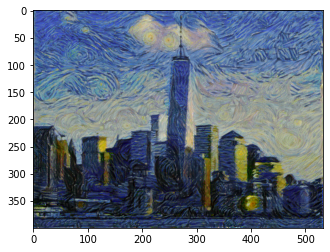

Total loss:  7192667.0


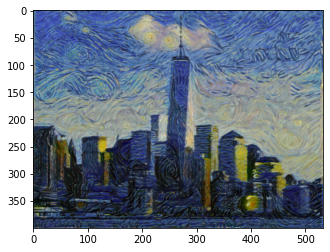

Total loss:  6564018.5


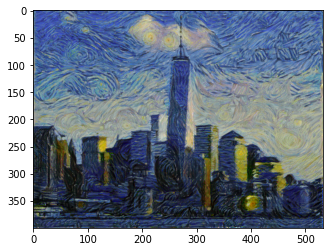

Total loss:  6033987.5


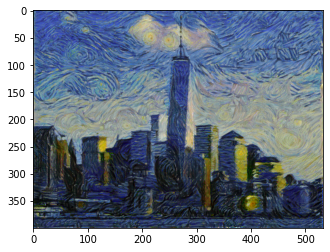

Total loss:  5661750.5


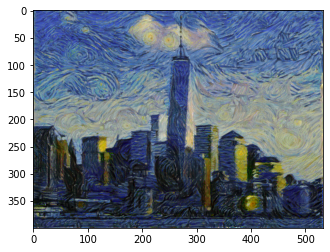

Total loss:  5369306.5


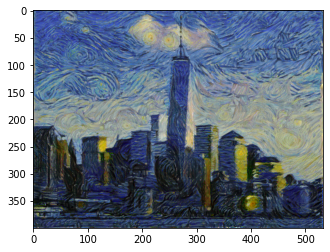

Total loss:  5085535.0


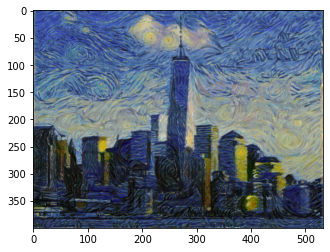

In [59]:
show_every = 400

# Optimizer
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
   
    ## Content loss
    target_features = get_features(target,vgg)
    content_loss = torch.mean((target_features['conv5_1'] - content_features['conv5_1'])**2)
    
    # The style loss
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        ## Target gram matrix
        target_gram = gram_matrix(target_feature)
       
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer]*torch.mean((style_gram - target_gram)**2)
        
       
        style_loss += layer_style_loss / (d * h * w)
        
        
    ##Total loss
    total_loss = content_weight*content_loss + style_weight*style_loss
    
   
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Intermediate images 
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

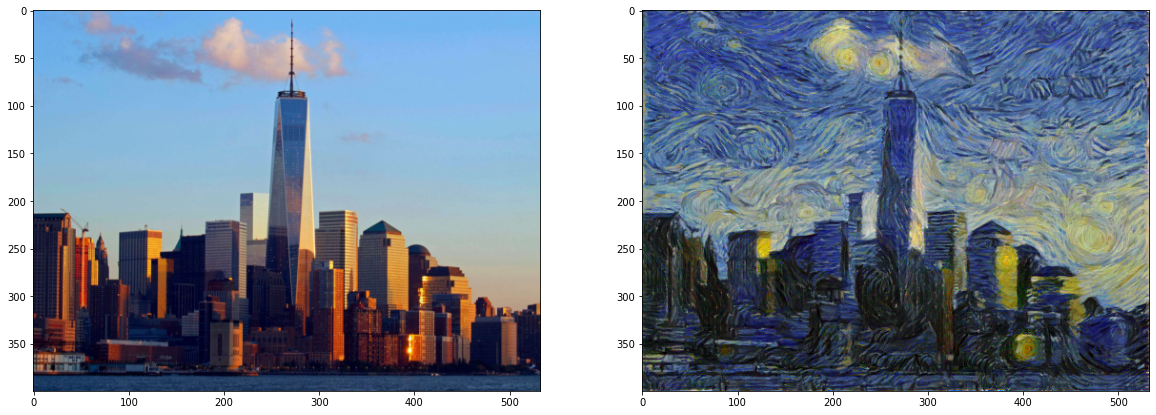

In [51]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))